In [1]:
from keras.datasets import boston_housing

(train_data,train_targets),(test_data,test_targets) \
= boston_housing.load_data("boston_housing.npz")

Using TensorFlow backend.


In [2]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [3]:
import numpy as np

mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis=0)
train_data/=std

# 测试数据的标准化，也只能使用训练数据的mean,std
test_data -= mean
test_data/=std

In [4]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',
                          input_shape =(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    # 注意没有激活层，是一个线性层，因为回归的是一个标量
    model.add(layers.Dense(1))
    # mse:均方误差
    # mae:平均绝对误差
    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['mae'])
    return model

In [5]:
import numpy as np

# 设定K为4，数据折成4段，也需要循环4次，
k = 4

num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('Processing fold #',i)
    val_data = train_data[i * num_val_samples 
                        : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples 
                        : (i+1) * num_val_samples]
    #数据合成
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i+1) * num_val_samples:]],
        axis = 0)

    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis = 0)
    #创建模型
    model = build_model()
    #开始训练
    model.fit(partial_train_data,
             partial_train_targets,
             epochs = num_epochs,
             batch_size = 1,
             verbose = 0)
    #进行验证
    val_mse,val_mae = model.evaluate(val_data,
                                    val_targets,
                                    verbose=0)
    all_scores.append(val_mae)

Processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [6]:
print(all_scores)
print("mean scorces:",np.mean(all_scores))

[2.076860425495865, 2.235849895099602, 2.8121557660622174, 2.312264413526743]
mean scorces: 2.3592826250461068


In [7]:
# 500 个轮次并记录模型的数据
import numpy as np

k = 4

num_val_samples = len(train_data) // k
num_epochs = 500
all_scores = []
all_mae_histories = []  

for i in range(k):
    print('Processing fold #',i)
    val_data = train_data[i * num_val_samples 
                        : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples 
                        : (i+1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i+1) * num_val_samples:]],
        axis = 0)

    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis = 0)
    model = build_model()
    history = model.fit(partial_train_data,
                 partial_train_targets,
                 validation_data = (val_data,val_targets),
                 epochs = num_epochs,
                 batch_size = 1,
                 verbose = 0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [10]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

print(average_mae_history[0])

4.796238698581658


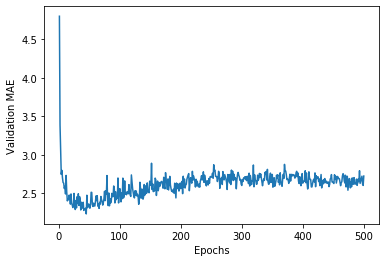

In [12]:
# 绘制验证分数
import matplotlib.pyplot as plt 

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history) 
plt.xlabel('Epochs') 
plt.ylabel('Validation MAE') 
plt.show()

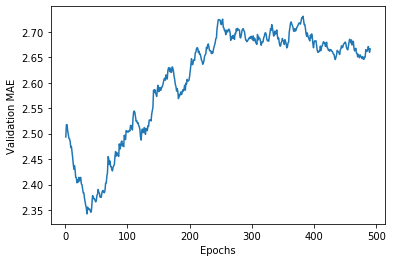

In [13]:
# 　绘制验证分数（删除前 10 个数据点）
def smooth_curve(points, factor=0.9): 
  smoothed_points = [] 
  for point in points: 
    if smoothed_points: 
      previous = smoothed_points[-1] 
      smoothed_points.append(previous * factor + point * (1 - factor)) 
    else: 
      smoothed_points.append(point) 
  return smoothed_points 

smooth_mae_history = smooth_curve(average_mae_history[10:]) 

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history) 
plt.xlabel('Epochs') 
plt.ylabel('Validation MAE') 
plt.show()

In [14]:
# 训练最终模型
model = build_model()
model.fit(train_data,
         train_targets,
         epochs = 80,
         batch_size = 16,
         verbose = 0)
test_mes_score,test_mae_score = model.evaluate(test_data,
                       test_targets)
print(test_mae_score)

102/102 [==============================] - 0s 880us/step
2.677694666619394


In [2]:
import tensorflow as tf
tf.__version__

'1.13.1'